In [196]:
import os
import cv2
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [9]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": 16
})

In [158]:
images = list(map(lambda name: name+'_256', [
    'airplane',
    'arctichare',
    'baboon',
    'barbara',
    'boat',
    'fruits',
    'lena',
    'monarch',
    'peppers',
    'zelda'
]))

#### Combine files

In [14]:
def combine_parts(methods=['RHFM', 'ZM', 'PZM'], parts='parts'):
    for method in methods:
        files = list(filter(lambda file: file.startswith(method) and os.path.isfile(parts+'/'+file), os.listdir(parts)))
        files = list(map(lambda file: parts+'/'+file, files))
        combined = pd.concat([pd.read_csv(f) for f in files ])
        combined.to_csv(method+'.csv', index=False)

In [21]:
combine_parts()

#### Prepare

In [113]:
def accumulate(data, on='L', rng=None):
    A = {
        'MSE': [],
        'SNR': [],
        'PSNR': []
    }
    if on == 'L':
        rng = range(0,129,8)
    elif on == 'qs':
        rng = rng or [ 1+q/10 for q in range(0,11) ]
    #
    for i in rng:
        means = data[data[on]==i].mean()
        for field in A:
            val = means[field]
            A[field].append(val)# if val != math.inf else 0)
    return A

In [33]:
rhfm = accumulate(pd.read_csv('RHFM.csv'))
zm = accumulate(pd.read_csv('ZM.csv'))
pzm = accumulate(pd.read_csv('PZM.csv'))

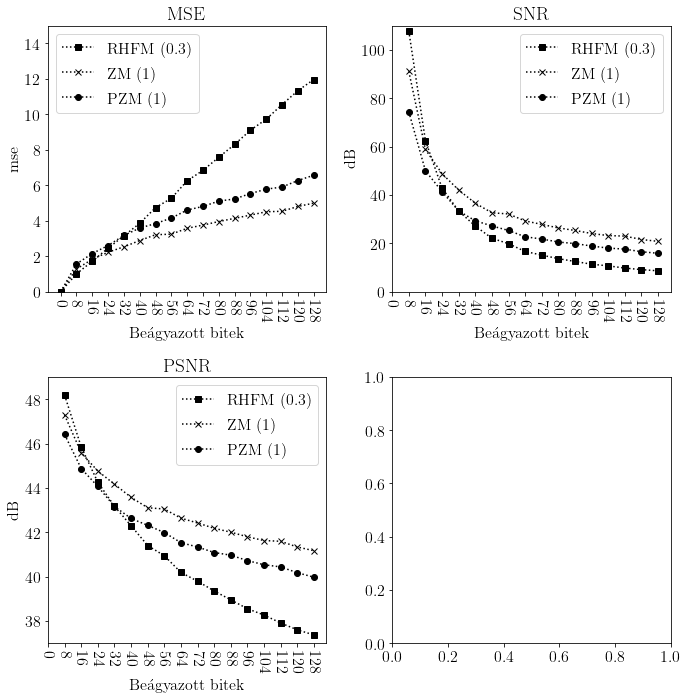

In [224]:
def plot_field(plt, ax, field, ylabel, ylim):
    global rhfm, zm, pzm
    ax.set_title(field)
    ax.plot(rhfm[field], 'k:s', label='RHFM (0.3)')
    ax.plot(zm[field], 'k:x', label='ZM (1)')
    ax.plot(pzm[field], 'k:o', label='PZM (1)')
    ax.set_xlabel('Beágyazott bitek')
    ax.set_ylabel(ylabel)
    ax.set_xticks(range(len(rhfm[field])))
    ax.set_xticklabels([ i for i in range(0,129,8) ])
    ax.set_ylim(ylim)
    plt.setp(ax.get_xticklabels(), rotation=270)
    ax.legend()
    
fig, axes = plt.subplots(2,2, figsize=(10,10))

plot_field(plt, axes[0,0], 'MSE', 'mse', (0,15))
plot_field(plt, axes[0,1], 'SNR', 'dB', (0,110))
plot_field(plt, axes[1,0], 'PSNR', 'dB', (37,49))

plt.tight_layout()
plt.savefig('compare_distortion.png', dpi=300)
plt.show()

In [225]:
combine_parts(['RHFM_'], parts='parts/RHFM_qs')
combine_parts(['ZM_'], parts='parts/ZM_qs')
combine_parts(['PZM_'], parts='parts/PZM_qs')

In [226]:
rhfm_ = accumulate(pd.read_csv('RHFM_.csv'), on='qs', rng=[ round(0.1+i/20,2) for i in range(0,9) ])
zm_ = accumulate(pd.read_csv('ZM_.csv'), on='qs')
pzm_ = accumulate(pd.read_csv('PZM_.csv'), on='qs')

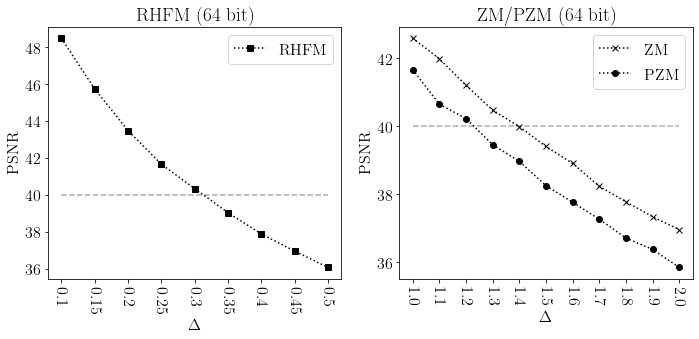

In [227]:
def plot_qs(plt, ax, title, data, labels):
    ax.set_title(title)
    ax.hlines(40, 0, len(data[0][1])-1, 'k', '--', alpha=0.33)
    for dat in data:
        ax.plot(dat[1], dat[2], label=dat[0])
    ax.set_xlabel('$\Delta$')
    ax.set_ylabel('PSNR')
    ax.set_xticks(range(len(data[0][1])))
    ax.set_xticklabels(labels)
    #ax.set_ylim((36,43))
    plt.setp(ax.get_xticklabels(), rotation=270)
    ax.legend()
    
fig, axes = plt.subplots(1,2, figsize=(10,5))

plot_qs(plt, axes[0], 'RHFM (64 bit)', [('RHFM', rhfm_['PSNR'], 'k:s')], [ round(0.1+i/20,2) for i in range(0,len(rhfm_['PSNR'])) ])
plot_qs(plt, axes[1], 'ZM/PZM (64 bit)', [('ZM', zm_['PSNR'], 'k:x'), ('PZM', pzm_['PSNR'], 'k:o')], [ 1+i/10 for i in range(0,len(zm_['PSNR'])) ])

plt.tight_layout()
plt.savefig('compare_qs.png', dpi=300)
plt.show()